# **Import Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import re
import subprocess
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from gensim.models import Word2Vec
from transformers import BertTokenizer, BertModel
import torch
import warnings
warnings.filterwarnings('ignore')
import nltk
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('omw-1.4')
# Download and unzip wordnet
try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /kaggle/working/...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /kaggle/working/corpora/wordnet.zip


replace /kaggle/working/corpora/wordnet/lexnames? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)


# **Load Dataset**

In [2]:
df=pd.read_csv(r'/kaggle/input/fake-news-classification/WELFake_Dataset.csv',index_col=0)
print(df.shape)
df.head()

(72134, 3)


,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,NaN,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


# **EDA**

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72134 entries, 0 to 72133
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   71576 non-null  object
 1   text    72095 non-null  object
 2   label   72134 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.2+ MB


In [4]:
df.dropna(inplace=True)

<Axes: ylabel='count'>

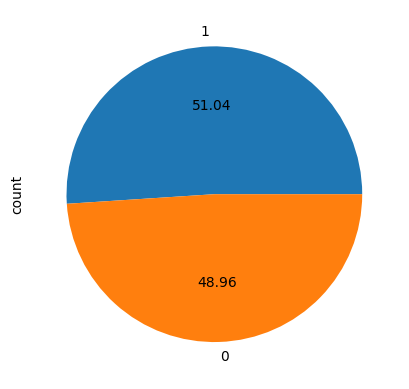

In [5]:
df.label.value_counts().plot.pie(autopct='%.2f')

In [6]:
df['full_text'] = df['title'] + ' ' + df['text']

In [7]:
def normalize_text(text):
    # 1. Convert text to lowercase
    text = text.lower()

    # 2. Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # 3. Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)

    # 4. Remove non-alphanumeric characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # 5. Tokenize the text
    tokens = word_tokenize(text)

    # 6. Remove stopwords and numeric tokens
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [
        token for token in tokens
        if token not in stop_words and token.isalpha()
    ]

    # 7. Lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    # 8. Join tokens back into a single string
    return ' '.join(lemmatized_tokens)

In [8]:
df['full_text']=df['full_text'].apply(normalize_text)

# **Visualizations**

In [9]:
fake_text = df[df.label == 0]['full_text']
real_text = df[df.label == 1]['full_text']

In [10]:
fake_text.head()

3     bobby jindal raised hindu us story christian c...
11    may brexit offer would hurt cost eu citizen eu...
12    schumer call trump appoint official oversee pu...
14    change expected espn political agenda despite ...
15    billionaire odebrecht brazil scandal released ...
Name: full_text, dtype: object

In [11]:
real_text.head()

0    law enforcement high alert following threat co...
2    unbelievable obamas attorney general say charl...
4    satan russia unvelis image terrifying new supe...
5    time christian group sue amazon splc designati...
6    dr ben carson targeted irs never audit spoke n...
Name: full_text, dtype: object

In [12]:
def plot_top_words(common_words, title):
    words, counts = zip(*common_words)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(counts), y=list(words), palette="viridis")
    plt.title(title)
    plt.xlabel("Frequency")
    plt.ylabel("Words")
    plt.tight_layout()
    plt.show()

In [13]:
fake_words_counter = Counter(' '.join(fake_text).split())
real_words_counter = Counter(' '.join(real_text).split())
top_fake_words = fake_words_counter.most_common(10)
top_real_words = real_words_counter.most_common(10)
print(top_fake_words)
print(top_real_words)

[('said', 184625), ('trump', 115031), ('mr', 71031), ('state', 70136), ('would', 62656), ('u', 62106), ('president', 51473), ('new', 50062), ('year', 46630), ('one', 43630)]
[('trump', 111219), ('u', 51345), ('people', 49018), ('clinton', 48198), ('said', 47061), ('one', 45964), ('would', 43036), ('state', 42822), ('president', 38225), ('hillary', 34432)]


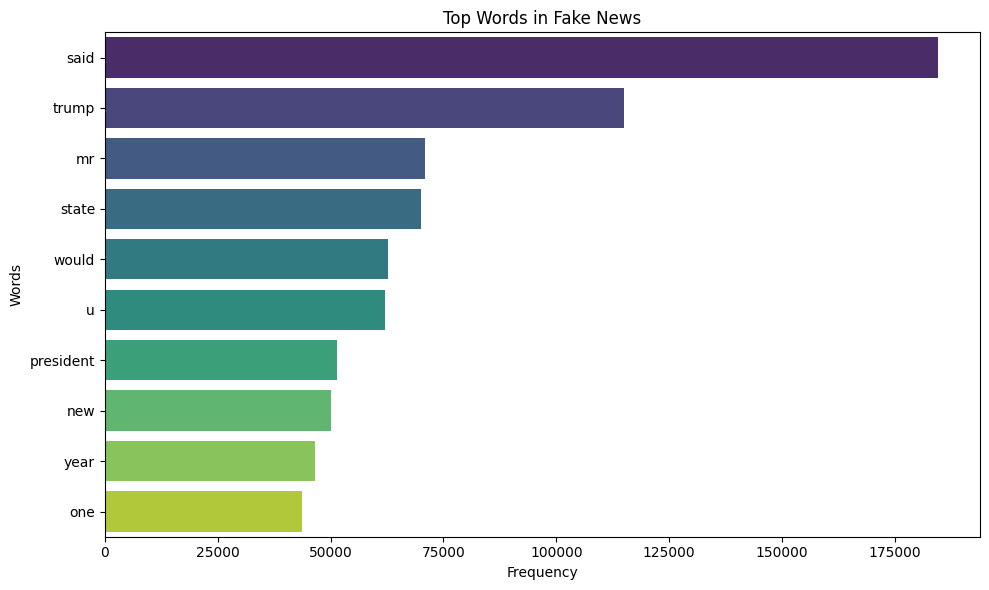

In [14]:
plot_top_words(top_fake_words, "Top Words in Fake News")

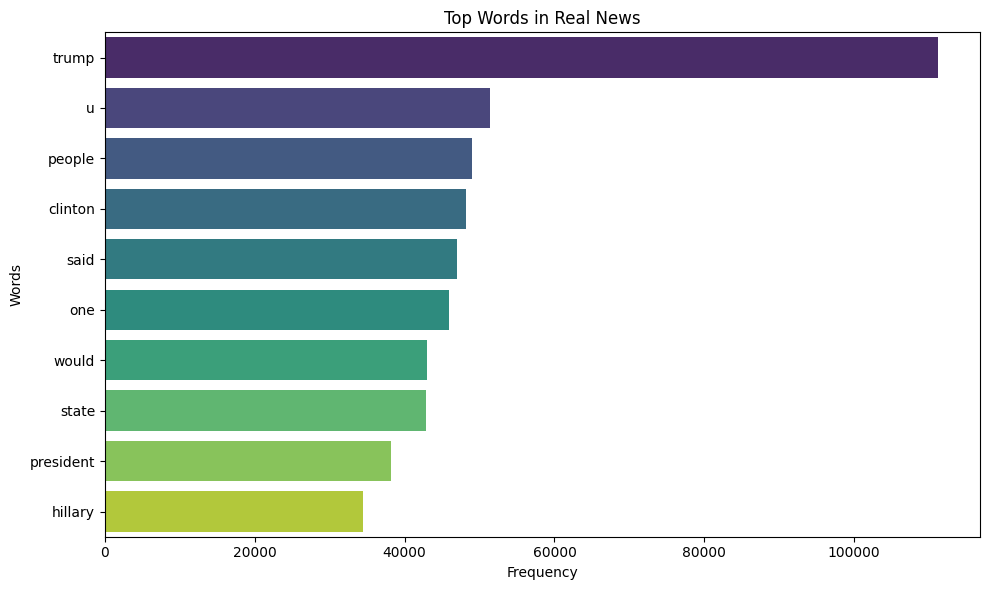

In [15]:
plot_top_words(top_real_words, "Top Words in Real News")

In [16]:
def generate_wordcloud_from_frequencies(word_frequencies, title):
    wordcloud = WordCloud(background_color='white').generate_from_frequencies(word_frequencies)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

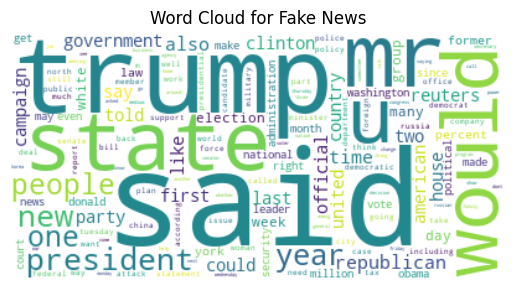

In [17]:
generate_wordcloud_from_frequencies(fake_words_counter, "Word Cloud for Fake News")

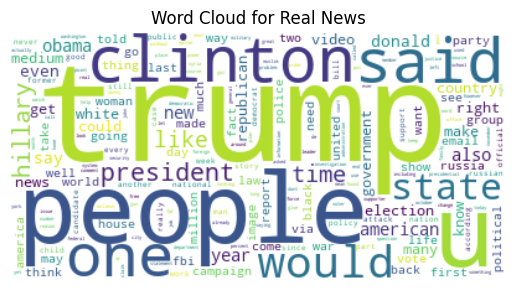

In [18]:
generate_wordcloud_from_frequencies(real_words_counter, "Word Cloud for Real News")

# **Model Training and Evaluation**

In [19]:
# Split Features and Target
X=df['full_text']
y=df['label']

In [20]:
# Perform TF-IDF vectorization
vectorizer = TfidfVectorizer(min_df=100, max_df=0.90, stop_words='english', max_features=10000)
X_tfidf = vectorizer.fit_transform(X).toarray()

In [21]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42, stratify=y)

In [22]:
# Define parameter grid
param_grid = {
    'n_estimators': [25, 50],
    'max_depth': [5, 10],
    'max_features': ['sqrt'],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initialize Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Perform Randomized Search with Cross-Validation
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=10,
    cv=3,
    scoring='accuracy',
    n_jobs=1,
    random_state=42
)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=1,
                   param_distributions={'max_depth': [5, 10],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [25, 50]},
                   random_state=42, scoring='accuracy')

In [24]:
# Print best parameters and score
print("Best Parameters:", random_search.best_params_)
print("Best Accuracy:", random_search.best_score_)

Best Parameters: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10}
Best Accuracy: 0.8857047813194573


In [26]:
# Use the best estimator for predictions
best_rf = random_search.best_estimator_
y_pred_tuned = best_rf.predict(X_test)
print("Tuned Model Accuracy:", accuracy_score(y_test, y_pred_tuned))
print("\nClassification Report:\n", classification_report(y_test, y_pred_tuned))

Tuned Model Accuracy: 0.8857981548783898

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.85      0.88      7006
           1       0.87      0.92      0.89      7302

    accuracy                           0.89     14308
   macro avg       0.89      0.89      0.89     14308
weighted avg       0.89      0.89      0.89     14308



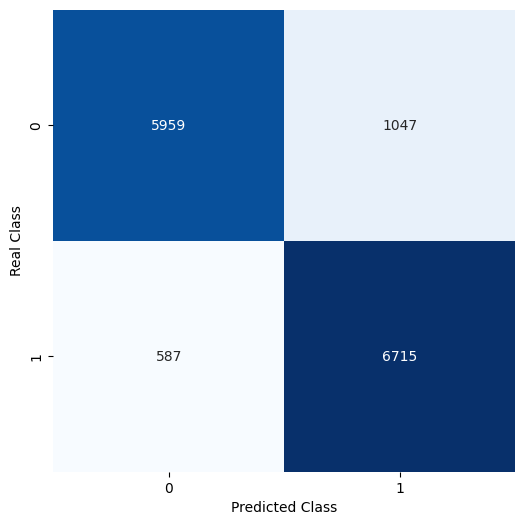

In [27]:
cm = confusion_matrix(y_test, y_pred_tuned)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, square=True)
plt.xlabel('Predicted Class')
plt.ylabel('Real Class')
plt.show()

In [28]:
# Get feature importance from the best Random Forest model
importances = best_rf.feature_importances_
feature_names = vectorizer.get_feature_names_out()
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

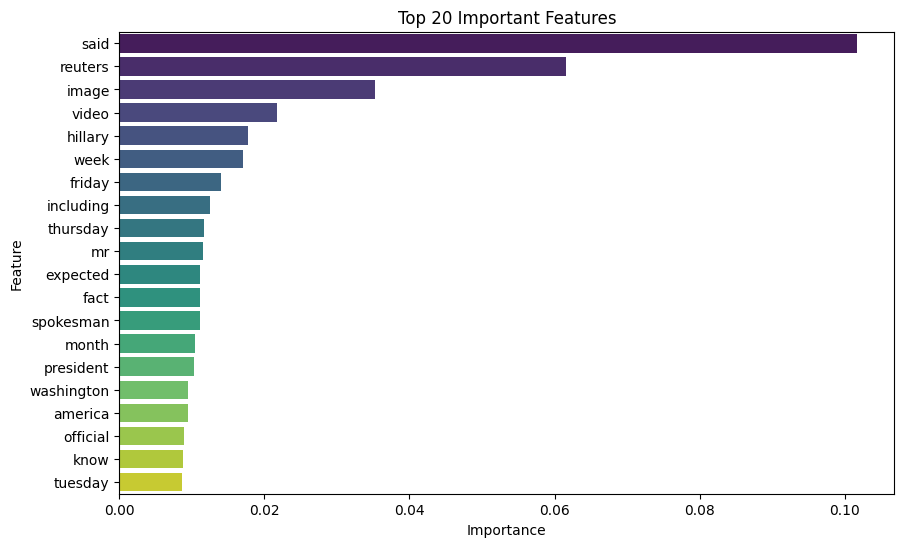

In [29]:
# Plot top 20 important features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20), palette='viridis')
plt.title('Top 20 Important Features')
plt.show()

# Feature Engineering with Word2Vec

In [30]:
# Tokenize text data for Word2Vec
tokenized_texts = df['full_text'].apply(lambda x: x.split())

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_texts, vector_size=100, window=5, min_count=1, workers=4)


# Define document vectorizer function
def doc_vectorizer(doc, model):
    doc_vec = np.zeros(model.vector_size)
    num_words = 0
    for word in doc:
        if word in model.wv:
            doc_vec += model.wv[word]
            num_words += 1
    return doc_vec / num_words if num_words > 0 else doc_vec


# Create document vectors
X_word2vec = np.array([doc_vectorizer(doc, word2vec_model) for doc in tokenized_texts])

In [31]:
# Split data for Word2Vec features
X_train_w2v, X_test_w2v, y_train, y_test = train_test_split(X_word2vec, y, test_size=0.2, random_state=42)

In [41]:
# Train Random Forest on Word2Vec features
rf_w2v = RandomForestClassifier(random_state=42)
rf_w2v.fit(X_train_w2v, y_train)

# Evaluate Word2Vec model
y_pred_w2v = rf_w2v.predict(X_test_w2v)
print("Word2Vec Model Accuracy:", accuracy_score(y_test, y_pred_w2v))
print("\nClassification Report:\n", classification_report(y_test, y_pred_w2v))

Word2Vec Model Accuracy: 0.9112384679899357

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.89      0.91      7081
           1       0.90      0.93      0.91      7227

    accuracy                           0.91     14308
   macro avg       0.91      0.91      0.91     14308
weighted avg       0.91      0.91      0.91     14308

